In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./data/divvy_daily.csv')
df = df[['date', 'rides']]
df['date'] = pd.to_datetime(df['date'])
df.columns = ['ds', 'y']

10:28:39 - cmdstanpy - INFO - Chain [1] start processing
10:28:39 - cmdstanpy - INFO - Chain [1] done processing


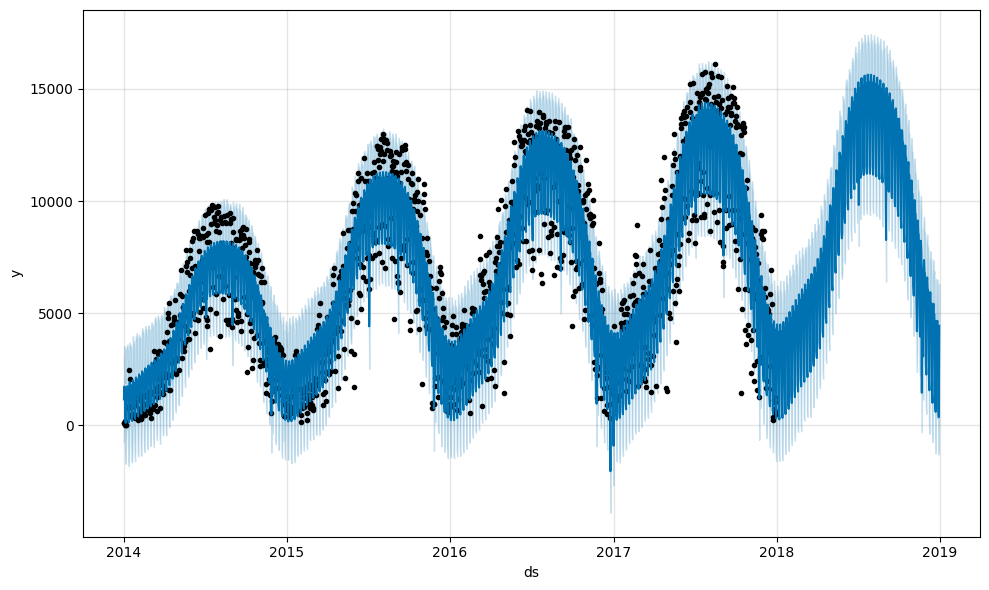

In [3]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4)

# Adicionando um feriado
model.add_country_holidays(country_name='US')

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.show()

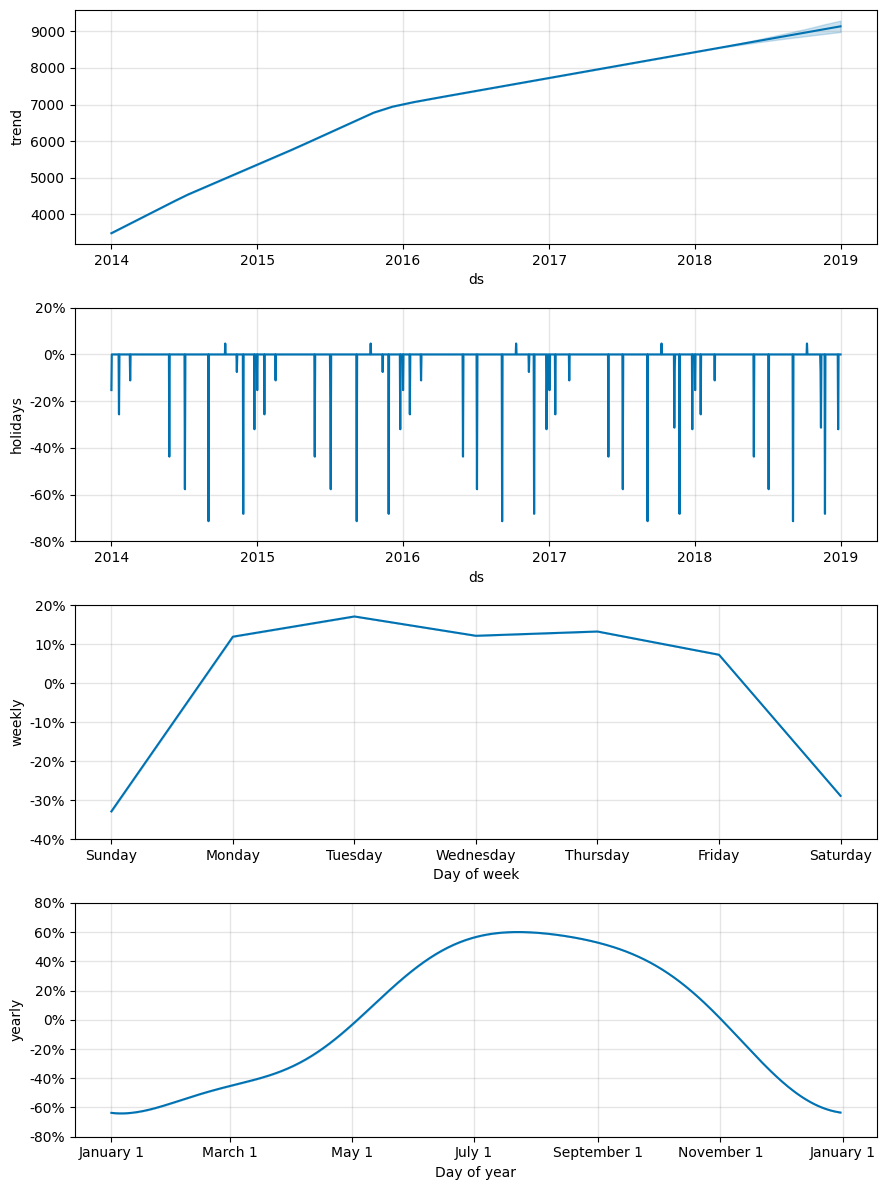

In [5]:
fig2 = model.plot_components(forecast)
plt.show()

In [7]:
# Identificando os feriados
model.train_holiday_names

0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                   Christmas Day
10       Christmas Day (Observed)
11      New Year's Day (Observed)
12        Veterans Day (Observed)
13    Independence Day (Observed)
dtype: object

In [32]:
# Construindo um DataFrame com o efeitos dos feriados

def  first_non_zeros(forecast, holiday):
    return forecast[forecast[holiday] != 0][holiday].values[0]

pd.DataFrame({'holiday': model.train_holiday_names,
              'effect': [first_non_zeros(forecast, holiday) for holiday in model.train_holiday_names],
              # 'effect_lower': [first_non_zeros(forecast, holiday+'_lower') for holiday in model.train_holiday_names],
              # 'effect_upper': [first_non_zeros(forecast, holiday+'_upper') for holiday in model.train_holiday_names],
             })

,holiday,effect
0,New Year's Day,-0.152648
1,Martin Luther King Jr. Day,-0.256200
2,Washington's Birthday,-0.111033
3,Memorial Day,-0.436939
4,Independence Day,-0.576436
5,Labor Day,-0.713158
6,Columbus Day,0.046695
7,Veterans Day,-0.075302
8,Thanksgiving,-0.681752
9,Christmas Day,-0.319944


### Adicionado feriados específico de estados

In [31]:
from prophet.make_holidays import make_holidays_df

In [62]:
year_list  = df['ds'].dt.year.unique().tolist()  # Results [2014, 2015, 2016, 2017]
year_list.append(year_list[-1] + 1) # Adicionando mais um ano na lista
holidays = make_holidays_df(year_list=year_list, country='US', state='IL')
holidays['ds'] = pd.to_datetime(holidays['ds'])
holidays.head()

,ds,holiday
0,2016-01-01,New Year's Day
1,2016-01-18,Martin Luther King Jr. Day
2,2016-02-12,Lincoln's Birthday
3,2016-02-15,Washington's Birthday
4,2016-03-07,Casimir Pulaski Day


In [63]:
# Adicionando os feriados ao modelo Prophet
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, holidays=holidays)

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

12:27:01 - cmdstanpy - INFO - Chain [1] start processing
12:27:01 - cmdstanpy - INFO - Chain [1] done processing


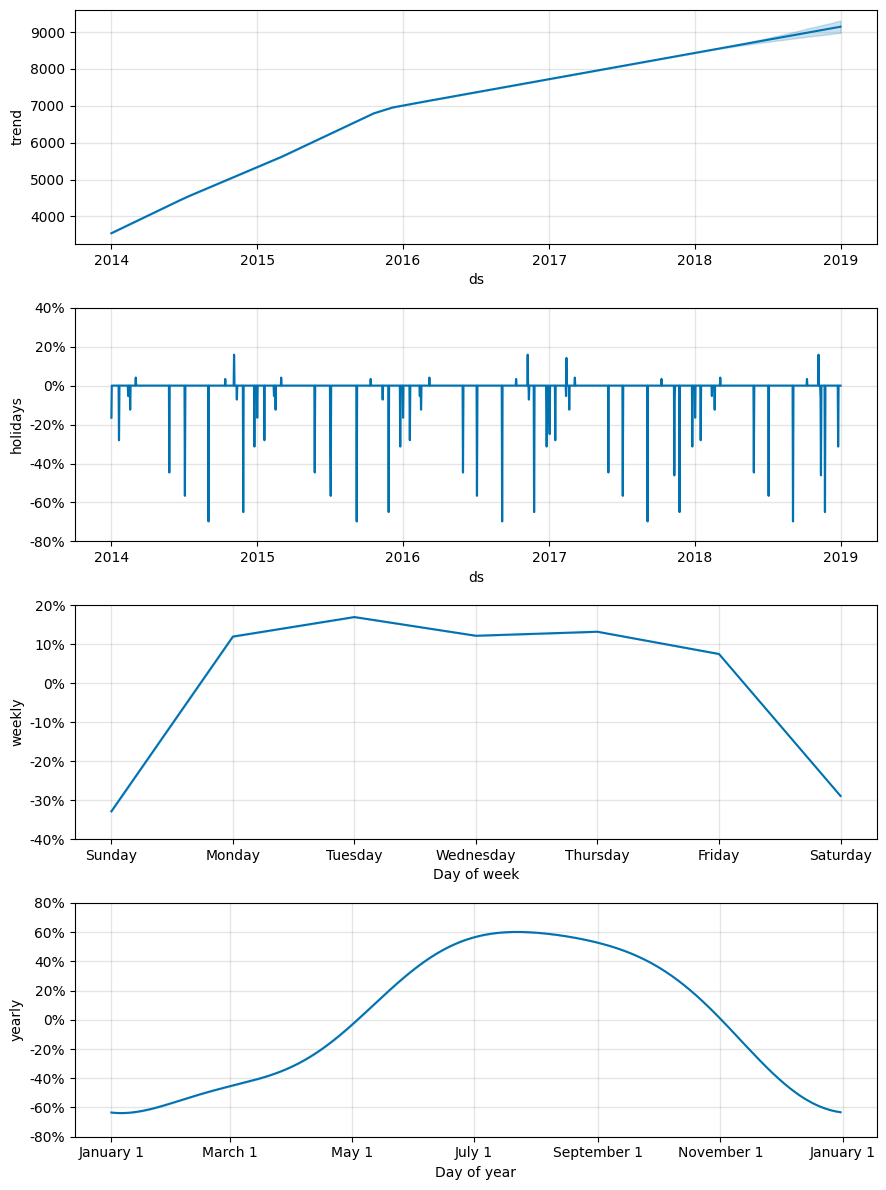

In [64]:
model.plot_components(forecast)
plt.show()

In [65]:
model.train_holiday_names

0                    New Year's Day
1        Martin Luther King Jr. Day
2                Lincoln's Birthday
3             Washington's Birthday
4               Casimir Pulaski Day
5                      Memorial Day
6                  Independence Day
7                         Labor Day
8                      Columbus Day
9                      Election Day
10                     Veterans Day
11                     Thanksgiving
12                    Christmas Day
13         Christmas Day (Observed)
14        New Year's Day (Observed)
15    Lincoln's Birthday (Observed)
16          Veterans Day (Observed)
17      Independence Day (Observed)
dtype: object

### Criando feriados customizados

Esses feriados podem ser datas tais como *Black Friday* e *Véspera de Natal*. Nessas data podem ter impactos na série temporal.

In [70]:
# Inserindo novos feriados no dataframe de holidays
# =================================================
holidays = make_holidays_df(year_list=year_list, country='US')

# Incluindo o black Friday
black_friday = pd.DataFrame({'holiday': 'Black Friday',
                             'ds': pd.to_datetime(
                                 [
                                     '2014-11-28',
                                     '2015-11-27',
                                     '2016-11-25',
                                     '2017-11-24',
                                     '2018-11-23',
                                 ])})

# Incluindo a Véspera de Natal
christmas_eve = pd.DataFrame({'holiday': 'Christmas Eve',
                              'ds': pd.to_datetime(
                                  [
                                      '2014-12-24',
                                      '2015-12-24',
                                      '2016-12-24',
                                      '2017-12-24',
                                      '2018-12-24',
                                   ])})

holidays = pd.concat([holidays, black_friday, christmas_eve]).sort_values('ds').reset_index(drop=True)
holidays

,ds,holiday
0,2014-01-01,New Year's Day
1,2014-01-20,Martin Luther King Jr. Day
2,2014-02-17,Washington's Birthday
3,2014-05-26,Memorial Day
4,2014-07-04,Independence Day
...,...,...
60,2018-11-12,Veterans Day (Observed)
61,2018-11-22,Thanksgiving
62,2018-11-23,Black Friday
63,2018-12-24,Christmas Eve


In [73]:
model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=4, holidays=holidays)

model.fit(df)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Results with Black Friday and Christmas Eve
model.train_holiday_names

12:50:21 - cmdstanpy - INFO - Chain [1] start processing
12:50:22 - cmdstanpy - INFO - Chain [1] done processing


0                  New Year's Day
1      Martin Luther King Jr. Day
2           Washington's Birthday
3                    Memorial Day
4                Independence Day
5                       Labor Day
6                    Columbus Day
7                    Veterans Day
8                    Thanksgiving
9                    Black Friday
10                  Christmas Eve
11                  Christmas Day
12    Independence Day (Observed)
13       Christmas Day (Observed)
14      New Year's Day (Observed)
15        Veterans Day (Observed)
dtype: object

### Criando feriados de múltiplos dias